# Team Lambda Capstone Project

Benjamin Houldridge

Catherine Laguna

Elija Martin

##Problem Definition

Using surveys taken post bootcamp from graduates of the Deep Dive Coding bootcamps, can we better understand the satisfaction of the students over time per bootcamp using Sentiment Analysis and other NLP techniques?



### Imports

In [1]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [2]:
!pip install wordcloud

used for image manipulation

In [3]:
!pip install --upgrade Pillow

     |████████████████████████████████| 2.2MB 5.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import preprocessing
import pickle
from textblob import TextBlob as tb
from wordcloud import  WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import plotly
import plotly.express as px
import plotly.graph_objects as go
import statistics
import scipy.cluster.hierarchy as shc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Functions

Q12 specific Data Cleaning:

In [6]:
# check each unique value and replace with
# convert to label encoding

def interpret_q12(bad_str):
  """Takes the stings given in the q12 column and returns a new series with usable entries"""

  #bad_str=combined_data['q12'].unique().copy()
  x = pd.Series(np.zeros(combined_data.shape[0]))
  for idx,item in enumerate(combined_data['q12']):
    if item not in bad_str:
      continue
    elif item == '10-Jun' or item=='0 - 5' or item == '4.1 - 6' or item=='8+' or item=='6.1 - 8' or item=='0 - 2' or item=='2.1 - 4':
      x[idx]='less than 10h'
    elif item =='15-Nov':
      x[idx]='10h - 15h'
    elif item == '16åÊ- 20':
      x[idx]='15h - 20h'
    elif item == '20+':
      x[idx]= 'greater than 20h'
  return x

Sentiment Function

In [7]:
def sentementize(comment):
  """This function will turn all instances of fed data into a sentament analysis."""
  if comment == 'No Response':
   return comment

  tb_comment = tb(comment)
  sent = tb_comment.sentiment
  sent_score = sent[0]
  return sent_score

Average Sentiment Function

In [8]:
def avg_sent(df):
  ''' Given a dataframe, return dictionary of number of responses and 
      sentiment averages.'''

  avg_results={}
  columns=df.columns
  avg_counts={}
  for column in columns:
    avg_results[column]=[df[column][df[column]!='No Response'].mean(),
                         df[column][df[column]!='No Response'].count()]

  return avg_results


Remove non-valuable words from Word Cloud

In [9]:
def remove_noise(input_text):
  ''' given an list of words, modify into lower case, remove punctuation 
      and return one string of words separated only by a space'''

  noise_list=['response','no', 'the', 'on' 'agree', 'disagree', 'and',
            'in', 'to', 'me', 'with', 'that', 'of', 'he', 'as', 'i',
            'strongly','agree', 'a', 'neutral', 'for', 'than',
            'an', 'so', 'yes','was','it', 'on', 'but', 'is', 'this',
            'would', 'my', 'be','did','they', 'were','you','we', 'can',
            'who', 'if', 'had', 'not', 'have', 'like','from', 'get',
            'or', 'at','up','out','do', 'are', 'about', 'very', 'one',
            'what', 'when','into','more','all','some','there','then',
            'us','only','over','will','didnt','going','im','dont','came',
            'said','lot','though','na','want','many','maybe','set']

  #---- remove punctuation
  # initializing punctuations string  
  punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
  x = [''.join(c for c in s if c not in punc) for s in input_text]
  
  words=[]
  for items in x:
    words.append(items.lower())
  #noise_free=[]
  noise_free=''
  for each in words:
    if each not in noise_list:
      #noise_free.append(each)
      noise_free=noise_free + each + ' '
  return noise_free

DDC WordCloud Helmet

In [10]:
def ddc_wordcloud(text_block, word_cnt):
  '''Given a list of words, returns a WordCloud with outline of DDC icon'''
 
  #Add error handling
  ddc_mask=np.array(Image.open('/content/drive/My Drive/Team Lambda/Images/deep dive_helmet_vector.png'))
  #mask_new=''
  #mask=mask_new,

  clean_words=remove_noise(text_block)
  text_blob=tb(clean_words)
  wc = WordCloud(background_color="white",  max_font_size=200, 
                max_words= word_cnt,  mask=ddc_mask, contour_width=2, 
                contour_color=(255,208,7)).generate(str(text_blob))
  return(wc)

---
##Data Collection and Sources


Data Source : Data was collected from the staff of Deep Dive Coding, the data is exit surveys from graduates of all bootcamps between 2014 and 2020. It was collected in the form of multiple CSV files.

###Read In Datasets

The following codeblocks are our data import paths and variables.

In [11]:
lib1720_path = '/content/drive/My Drive/Team Lambda/Data/2017-2019.csv'
lib19_path = '/content/drive/My Drive/Team Lambda/Data/2019.csv'
lib20_path = '/content/drive/My Drive/Team Lambda/Data/2020.csv'
lib17_path = '/content/drive/My Drive/Team Lambda/Data/2017.csv'
lib1417_path = '/content/drive/My Drive/Team Lambda/Data/2014-2017.csv'
grad_path='/content/drive/My Drive/Team Lambda/Data/Grads_all.csv'

In [12]:
nlp1720 = pd.read_csv(lib1720_path,encoding = 'ISO-8859-1')

In [13]:
nlp19 = pd.read_csv(lib19_path, encoding = 'ISO-8859-1')

In [14]:
nlp20 = pd.read_csv(lib20_path, encoding = 'ISO-8859-1')

In [15]:
nlp17 = pd.read_csv(lib17_path, encoding = 'ISO-8859-1')    

In [16]:
nlp1417 = pd.read_csv(lib1417_path, encoding = 'ISO-8859-1')  

In [17]:
grad=pd.read_csv(grad_path, encoding='ISO-8859-1')   # file with graduate/survey response data

##Data Cleaning

###Fill in Missing Bootcamp

nlp17 and npl1417 data all comes from the fullstack web development couse. This information was not included in the datasets and so needed to be added.

In [18]:
nlp17['Which bootcamp did you attend?'] = 'Fullstack Web Development'
nlp1417['Which bootcamp did you attend?'] = 'Fullstack Web Development'

Some rows where missing information about which bootcamp was attended. Andrea Sisneros Wichman provided the missing information.

In [19]:
nlp19.loc[30,'Which bootcamp did you attend?'] = 'Fullstack Web Development'
nlp20.loc[23,'Which bootcamp did you attend?'] = 'Internet of Things (IoT)'
nlp20.loc[25,'Which bootcamp did you attend?'] = 'Internet of Things (IoT)'
nlp20.loc[42,'Which bootcamp did you attend?'] = 'Digital Media'
nlp20.loc[54,'Which bootcamp did you attend?'] = 'Fullstack Web Development'

###Synchronization of Column Names

To create unified column names that will adhere to each question, the column names for each dataset will be redefined. Below is a set of dictionaries that map the old column names to new codes that represent each unique question. The first two smaller dictionaries exist because some of the data sets share the same column names but they correspond to different questions. The two smaller dictionaries will change a few of the names on their respective datasets then the large dictionary will be ran on all datasets to produce unified column names.

In [20]:
column_names_mapped_nlp19 = {
    'Unnamed: 35': 'p14_s_r',
    'Unnamed: 43': 'qsue_r',
    'Unnamed: 47': 'qstem_r'
}

column_names_mapped_nlp20 = {
    'Unnamed: 35': 'p14_s_r',
    'Unnamed: 37': 'q14_1_r',
    'Unnamed: 43': 'qsue_r',
    'Unnamed: 47': 'qeste_r'
}

column_names_mapped_nlp1417 = {
    'Unnamed: 35': 'q_s_5_r',
    'Unnamed: 37': 'q_s_6_r'
}

column_names_mapped_nlp17 = {
    'Unnamed: 13': 'q4_r',
    'Unnamed: 15': 'q5_r',
    'Unnamed: 17': 'q6_r',
    'Unnamed: 19': 'q7_r',
    'Unnamed: 21': 'q8_r',
    'Unnamed: 29': 'q12_r',
    'Unnamed: 31': 'q1_r'
}

In [21]:
column_names_mapped = {
    'Which bootcamp did you attend?':'q1',
    'Would you recommend this course to others?':'q1_1',
    'Unnamed: 10':'q1_r',
    'I understood the goals and objectives of this course when it began:':'q2',
    'Unnamed: 12': 'q2_r',
    'The goals and objectives of this course, as I understand them, are met at this time:': 'q3',
    'Unnamed: 14': 'q3_r',
    'The requirements and grading system for the course were clear:': 'q4',
    'Unnamed: 16': 'q4_r',
    'The instructors treated me with respect:': 'q5',
    'Unnamed: 18': 'q5_r',
    'The instructors were available to help when asked:': 'q6',
    'Unnamed: 20': 'q6_r',
    'The instructors were knowledgeable about the course material:': 'q7',
    'Unnamed: 22': 'q7_r',
    'The instructors were organized and prepared:': 'q8',
    'Unnamed: 24': 'q8_r',
    'I am satisfied with the format of the instruction:': 'q9',
    'Unnamed: 26': 'q9_r',
    'The pace of the course was conducive to my learning:': 'q10',
    'Unnamed: 28': 'q10_r',
    'The level of the course material was conducive to my learning:': 'q11',
    'Unnamed: 30': 'q11_r',
    'On average, how many hours per week have you spent, outside of the classroom, on this course?': 'q12',
    'Unnamed: 32': 'q12_r',
    'Are there any changes you would recommend for this course?': 'q13_r',
    'Did you have any concerns before beginning the bootcamp and if so, were those concerns alleviated?': 'q14',
    'Unnamed: 35': 'q14_r',
    'Who challenged you the most?': 'q15_r',
    'Who made you feel the most comfortable?': 'q16_r',
    'Who was your favorite guest instructor or speaker? Why?': 'q17_r',
    'Who was your LEAST favorite guest instructor or speaker? Why?': 'q18_r',
    'I had a good experience with myåÊBootcamp Success Manager (Sue):': 'qsue',
    'Unnamed: 41': 'qsue_r',
    'I had a good experience withåÊmy Pro Dev instructor (Daniel):': 'qdan',
    'Unnamed: 43': 'qdan_r',
    'I had a good experience with the Program Manager (Devonna):': 'qdev',
    'Unnamed: 45': 'qdev_r',
    'The STEMulus Center provided an effective learning environment:': 'qstem',
    'Unnamed: 47': 'qstem_r',
    'Would you like to leave a review about your bootcamp experience?åÊIf so, please write a short testimonial. It may be used for our marketing purposes.': 'q23_r',
    'One a scale of 1-10, 1 being lowest and 10 highest, how likely areåÊyou toåÊ recommend this course to others?':'q1_1',
    'Did you have any concerns before beginning the bootcamp?': 'q14_s',
    'If you did have concerns before beginning the bootcamp, were those concerns alleviated?': 'q14_1',
    'Unnamed: 37' : 'q14_1_1',
    'Respondent ID': 'Respondent ID',
    'Collector ID': 'Collector ID',
    'Start Date': 'Start Date',
    'End Date': 'End Date',
    'Email Address': 'Email Address',
    'First Name': 'First Name',
    'Last Name': 'Last Name',
    'Custom Data 1': 'Custom Data 1',
    'I had a good experience with the Employer Relations Manager (Esteban):': 'qeste',
    'Unnamed: 49':'qstem_r',
    'Unnamed: 9' : 'q2_r',
    'Unnamed: 11' : 'q3_r',
    'Unnamed: 13' : 'q5_r',
    'Unnamed: 15' : 'q4_r',
    'Unnamed: 17' : 'q_s_1_r',
    'Unnamed: 19' : 'q6_s_r',
    'Unnamed: 21' : 'q8_s_r',
    'Unnamed: 23' : 'q9_r',
    'Unnamed: 25' : 'q10_r',
    'Unnamed: 27' : 'q11_r',
    'Unnamed: 29' : 'q_s_2_r',
    'Unnamed: 31' : 'q_s_3_r',
    'Unnamed: 34' : 'q14_r',
    'I had a good experience with my Student Success Specialist (Karen):' : 'qkar',
    'Unnamed: 38' : 'qkar_r',
    'I had a good experience with my Career Coach (Daniel):' : 'qdan',
    'Unnamed: 40' : 'qdan_r',
    'I had a good experience with the Senior Program Manager (Andrea):' : 'qand',
    'Unnamed: 42' : 'qand_r',
    'Unnamed: 44' : 'qstem_r',
    'Would you like to leave a testimonial? If we may use it for marketing purposes, please include your name.åÊ' : 'q23_r',
    'I understood the goals/objective of this course at the beginning of the course:' : 'q2',
    'The goals/objective of this course, as I understand them, are met at this time:' : 'q3',
    'My instructor treated me with respect:' : 'q5',
    'I felt free to ask questions in the course:' : 'q_s_1',
    'The instructor answered my questions when I asked them:' : 'q6_s',
    "The instructor's course presentations were organized:" : 'q8_s',
    'The textbook helped me to learn:' : 'q_s_2',
    'Homework assignments helped me better understand the course material:' : 'q_s_3',
    'The instructor was willing to work with me outside of the class:' : 'q_s_4',
    'Unnamed: 33' : 'q_s_4_r',
    'The instructor evaluated my learning based on course material presented and course requirements:' : 'q_s_5',
    'I have become more competent in this area due to this course:' : 'q_s_6',
    'Unnamed: 39' : 'q12_r',
    'List one or more aspects of the course that you liked:' : 'q_s_7_r'

    }

The above dictionary needs to be checked for human error. To test the above dictionary we need to make sure that all current column names are mapped to their new code. The below function will affirm that all column names in a given column have a mapping and return any that have been missed. 

In [22]:
def check_column_names(dataframe):
  """Check if all column names in dataframe are in the dictionary as keys."""

  output = []
  for column in dataframe.columns:
    if column in column_names_mapped:
      continue
    else:
      output.append(column)
  if len(output) == 0:
    return 'All column names are found in dictionary'
  else:
    return output

Ensure against human error.

In [23]:
check_column_names(nlp1720)
check_column_names(nlp19)
check_column_names(nlp20)
check_column_names(nlp17)
check_column_names(nlp1417)

'All column names are found in dictionary'

Rename the columns in all datasets using the above mapping.

In [24]:
nlp19.rename(column_names_mapped_nlp19, axis= 1, inplace=True)
nlp20.rename(column_names_mapped_nlp20, axis= 1, inplace=True)
nlp17.rename(column_names_mapped_nlp17, axis= 1, inplace=True)
nlp1417.rename(column_names_mapped_nlp1417, axis= 1, inplace=True)
nlp19.rename(column_names_mapped, axis= 1, inplace=True)
nlp20.rename(column_names_mapped, axis= 1, inplace=True)
nlp1720.rename(column_names_mapped, axis= 1, inplace=True)
nlp17.rename(column_names_mapped, axis= 1, inplace=True)
nlp1417.rename(column_names_mapped, axis= 1, inplace=True);

Check if all column names are mapped to codes.

In [25]:
print(nlp1720.columns)
print(nlp19.columns)
print(nlp20.columns)
print(nlp17.columns)
print(nlp1417.columns)

Index(['Respondent ID', 'Collector ID', 'Start Date', 'End Date',
       'Email Address', 'First Name', 'Last Name', 'Custom Data 1', 'q1',
       'q1_1', 'q1_r', 'q2', 'q2_r', 'q3', 'q3_r', 'q4', 'q4_r', 'q5', 'q5_r',
       'q6', 'q6_r', 'q7', 'q7_r', 'q8', 'q8_r', 'q9', 'q9_r', 'q10', 'q10_r',
       'q11', 'q11_r', 'q12', 'q12_r', 'q13_r', 'q14', 'q14_r', 'q15_r',
       'q16_r', 'q17_r', 'q18_r', 'qsue', 'qsue_r', 'qdan', 'qdan_r', 'qdev',
       'qdev_r', 'qstem', 'qstem_r', 'q23_r'],
      dtype='object')
Index(['Respondent ID', 'Collector ID', 'Start Date', 'End Date',
       'Email Address', 'First Name', 'Last Name', 'Custom Data 1', 'q1',
       'q1_1', 'q1_r', 'q2', 'q2_r', 'q3', 'q3_r', 'q4', 'q4_r', 'q5', 'q5_r',
       'q6', 'q6_r', 'q7', 'q7_r', 'q8', 'q8_r', 'q9', 'q9_r', 'q10', 'q10_r',
       'q11', 'q11_r', 'q12', 'q12_r', 'q13_r', 'q14_s', 'p14_s_r', 'q14_1',
       'q14_1_1', 'q15_r', 'q16_r', 'q17_r', 'q18_r', 'qsue', 'qsue_r', 'qdev',
       'qdev_r', 'qstem', '

Append the five data sets into one unified data frame.

In [26]:
combined_data = nlp1720.append([nlp19, nlp20, nlp17, nlp1417], ignore_index=True, sort=True)
combined_data.head()

,Collector ID,Custom Data 1,Email Address,End Date,First Name,Last Name,Respondent ID,Start Date,p14_s_r,q1,q10,q10_r,q11,q11_r,q12,q12_r,q13_r,q14,q14_1,q14_1_1,q14_1_r,q14_r,q14_s,q15_r,q16_r,q17_r,q18_r,q1_1,q1_r,q2,q23_r,q2_r,q3,q3_r,q4,q4_r,q5,q5_r,q6,q6_r,q6_s,q6_s_r,q7,q7_r,q8,q8_r,q8_s,q8_s_r,q9,q9_r,q_s_1,q_s_1_r,q_s_2,q_s_2_r,q_s_3,q_s_3_r,q_s_4,q_s_4_r,q_s_5,q_s_5_r,q_s_6,q_s_6_r,q_s_7_r,qand,qand_r,qdan,qdan_r,qdev,qdev_r,qeste,qeste_r,qkar,qkar_r,qstem,qstem_r,qsue,qsue_r
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Response,Response,Other (please specify),Response,Other (please specify),Response,Other (please specify),Open-Ended Response,Response,NaN,NaN,NaN,PleaseåÊexplain why,NaN,Open-Ended Response,Open-Ended Response,Open-Ended Response,Open-Ended Response,Response,Why or why not?,Response,Open-Ended Response,Other (please specify),Response,Other (please specify),Response,Other (please specify),Response,Other (please specify),Response,Other (please specify),NaN,NaN,Response,Other (please specify),Response,Other (please specify),NaN,NaN,Response,Other (please specify),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Response,Other (please specify),Response,Other (please specify),NaN,NaN,NaN,NaN,Response,Other (please specify),Response,Other (please specify)
1,175557115.0,NaN,NaN,9/12/19 10:52,NaN,NaN,7.025712e+09,9/12/19 10:23,NaN,Fullstack Web Development,Agree,The pace is quick. Don't blink or you'll miss ...,Agree,Addressing such a wide variety of levels of kn...,10-Jun,The potential rabbit hole to keep digging and ...,I think the capstones should come with a bit m...,No,NaN,NaN,NaN,NaN,NaN,"Marty with his ninja JavaScript skills, George...",Paul. He promised early on to work to earn my ...,Tough to pick between Andrea with the Project ...,There is no one at the bottom of this list.,Yes,I already do! I think this is a great opportun...,Agree Strongly,Deep Dive Coding Camps hold the potential to c...,They were clearly stated and with such an exte...,Agree Strongly,The road map was clearly stated and fairly wel...,Agree Strongly,"I appreciate the grading structure, as it depe...",Agree Strongly,The instructors (aka oracles) were all incredi...,Agree,"Even within a small cohort, sometimes it felt ...",NaN,NaN,Agree Strongly,It is hard to imagine how much more our instru...,Agree Strongly,It's interesting to see the mountain of curric...,NaN,NaN,Agree,Knowing that this was a transition class betwe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Agree Strongly,Dan was insightful and candid. I believe his c...,Agree Strongly,Devonna is a calm port in the center of the st...,NaN,NaN,NaN,NaN,Agree,It's loud with ventilation and a dozen plus pe...,Agree Strongly,I am so happy Sue joined during our cohort! Sh...
2,175557115.0,NaN,NaN,9/12/19 10:51,NaN,NaN,7.025711e+09,9/12/19 10:24,NaN,Fullstack Web Development,Neutral,"It was very fast paced. At times, like drinkin...",Neutral,I think I could have been better prepared in b...,10-Jun,NaN,More foundations in Javascript.,Yes,NaN,NaN,NaN,NaN,NaN,Paul,Paul made me feel most comfortable. I enjoyed ...,I really enjoyed learning from Rochelle. She e...,NaN,Yes,However- I would recommend that people take so...,Agree,NaN,NaN,Agree,NaN,Agree Strongly,NaN,Agree Strongly,I was very pleased with the way I was treated.,Agree,Most of the time they could help.,NaN,NaN,Agree,They were very knowledgeable.,Neutral,There were some lectures that seemed to be hap...,NaN,NaN,Agree,I learned the best by doing.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Agree,NaN,Neutral,NaN,NaN,NaN,NaN,NaN,Agree Strongly,NaN,Agree Strongly,NaN
3,175557115.0,NaN,NaN,9/12/19 10:50,NaN,NaN,7.025711e+09,9/12/19 10:23,NaN,Fullstack Web Development,Neutral,"I came in knowing it would be very fast paced,...",Agree,NaN,16åÊ- 20,NaN,"As mentioned above in question 9, providing ju...",No,NaN,NaN,NaN,NaN,NaN,I think Paul challenged us the most by really ...,Brent and George were pro

###Extract Year of Survey from EndDate
In order to evaluate sentiment <b> over time </b> need a time stamp in the dataframe. Will extract year from 'End Date' field. 'End Date' field only demarks when survey was completed but for our purposes will work.


In [27]:
#create a new column that contains year in 'End Date'
for each in range(len(combined_data['End Date'])):
  combined_data['year']=pd.DatetimeIndex(combined_data['End Date']).year

In [28]:
combined_data['year'] = combined_data['year'].astype('object')

###Delete Useles Columns and Rows

Drop unusable columns, and top row.

In [29]:
combined_data.drop(['Collector ID', 'Custom Data 1', 'Email Address', 'End Date', 'First Name', 'Last Name', 'Respondent ID', 'Start Date', 'qkar_r', 'qand_r'], axis=1, inplace=True)

Drop unusable rows.

In [30]:
hedder_rows = combined_data[combined_data['q3']=='Response'].index

In [31]:
combined_data.drop(hedder_rows, axis=0, inplace=True)

Reindex

In [32]:
combined_data.reset_index(drop=True, inplace=True)

###Clean Individual Columns

Question 12 Cleanup: 
"On average, how many hours per week have you spent, outside of the classroom, on this course? Responses (field values) were ugly which required specific coding.

In [33]:
# collect list of bad strings
bad_str=combined_data['q12'].unique()
bad_str

array(['10-Jun', '16åÊ- 20', '15-Nov', '0 - 5', '20+', '4.1 - 6', '8+',
       '6.1 - 8', '0 - 2', '2.1 - 4'], dtype=object)

Clean q12

In [34]:
combined_data['q12'] = interpret_q12(bad_str)
combined_data['q12'].unique()

array(['less than 10h', '15h - 20h', '10h - 15h', 'greater than 20h'],
      dtype=object)

Question 1_1 Conversion:

Given the three datasets: nlp1720, nlp19, nlp20, there was a change to how responses were requested from binary (Y,N) to a Likert scale (1 - 10) for the question "Would you recommend this course to others?"

To address these differences it was decided to collapse the Likert scale into a Binary pattern.

| Likert Scale | Binary Value |
|-|-|
| <=5 |	N |
| >5 |	Y |


In [35]:
combined_data['q1_1'].fillna('No Response', inplace=True)

In [36]:
combined_data['q1_1'].unique()

array(['Yes', 'No Response', 'No', '9', '10', '8', '7', '2', '4', '5',
       '3', '6'], dtype=object)

replace Likert scale values with binary values

In [37]:
for idx,item in enumerate(combined_data['q1_1']):
  if item=='Yes' or item=='No' or item=='No Response':
    continue
  elif int(item)>5:
    combined_data['q1_1'][idx]='Yes'
  else:
    combined_data['q1_1'][idx] ='No'

In [38]:
combined_data['q1_1'].unique()

array(['Yes', 'No Response', 'No'], dtype=object)

Fill Nan values wtih 'No Response'

In [39]:
clean_data = combined_data.fillna('No Response').copy()

Reset index

In [40]:
clean_data.reset_index(drop=True, inplace=True)

In [41]:
clean_data.head(2)

,p14_s_r,q1,q10,q10_r,q11,q11_r,q12,q12_r,q13_r,q14,q14_1,q14_1_1,q14_1_r,q14_r,q14_s,q15_r,q16_r,q17_r,q18_r,q1_1,q1_r,q2,q23_r,q2_r,q3,q3_r,q4,q4_r,q5,q5_r,q6,q6_r,q6_s,q6_s_r,q7,q7_r,q8,q8_r,q8_s,q8_s_r,q9,q9_r,q_s_1,q_s_1_r,q_s_2,q_s_2_r,q_s_3,q_s_3_r,q_s_4,q_s_4_r,q_s_5,q_s_5_r,q_s_6,q_s_6_r,q_s_7_r,qand,qdan,qdan_r,qdev,qdev_r,qeste,qeste_r,qkar,qstem,qstem_r,qsue,qsue_r,year
0,No Response,Fullstack Web Development,Agree,The pace is quick. Don't blink or you'll miss ...,Agree,Addressing such a wide variety of levels of kn...,less than 10h,The potential rabbit hole to keep digging and ...,I think the capstones should come with a bit m...,No,No Response,No Response,No Response,No Response,No Response,"Marty with his ninja JavaScript skills, George...",Paul. He promised early on to work to earn my ...,Tough to pick between Andrea with the Project ...,There is no one at the bottom of this list.,Yes,I already do! I think this is a great opportun...,Agree Strongly,Deep Dive Coding Camps hold the potential to c...,They were clearly stated and with such an exte...,Agree Strongly,The road map was clearly stated and fairly wel...,Agree Strongly,"I appreciate the grading structure, as it depe...",Agree Strongly,The instructors (aka oracles) were all incredi...,Agree,"Even within a small cohort, sometimes it felt ...",No Response,No Response,Agree Strongly,It is hard to imagine how much more our instru...,Agree Strongly,It's interesting to see the mountain of curric...,No Response,No Response,Agree,Knowing that this was a transition class betwe...,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,Agree Strongly,Dan was insightful and candid. I believe his c...,Agree Strongly,Devonna is a calm port in the center of the st...,No Response,No Response,No Response,Agree,It's loud with ventilation and a dozen plus pe...,Agree Strongly,I am so happy Sue joined during our cohort! Sh...,2019.0
1,No Response,Fullstack Web Development,Neutral,"It was very fast paced. At times, like drinkin...",Neutral,I think I could have been better prepared in b...,less than 10h,No Response,More foundations in Javascript.,Yes,No Response,No Response,No Response,No Response,No Response,Paul,Paul made me feel most comfortable. I enjoyed ...,I really enjoyed learning from Rochelle. She e...,No Response,Yes,However- I would recommend that people take so...,Agree,No Response,No Response,Agree,No Response,Agree Strongly,No Response,Agree Strongly,I was very pleased with the way I was treated.,Agree,Most of the time they could help.,No Response,No Response,Agree,They were very knowledgeable.,Neutral,There were some lectures that seemed to be hap...,No Response,No Response,Agree,I learned the best by doing.,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,No Response,Agree,No Response,Neutral,No Response,No Response,No Response,No Response,Agree Strongly,No Response,Agree Strongly,No Response,2019.0


###Convert Likert Scale to Numerical

Since the polarity score for the Sentiment analysis using TextBlob is on a scale of -1 to 1, we used a similar scale with a different ratio to represent the input from likert scale responses numerically. This scale was halved late on in the project to match the TextBlob polarity scale. This was done so they could be compared in a visualization.

In [42]:
clean_data.replace('Agree Strongly',2, inplace=True)
clean_data.replace('Agree',1, inplace=True)
clean_data.replace('Neutral',0, inplace=True)
clean_data.replace('Disagree',-1, inplace=True)
clean_data.replace('Disagree Strongly',-2, inplace=True)

In [43]:
clean_data_post_likert = clean_data.copy()

###Pickle Clean Data

Export data via pickle.

In [44]:
file_path = '/content/drive/My Drive/Team Lambda/Pickled Files/clean_data_post_likert.p'

In [45]:
pd.to_pickle(clean_data_post_likert, open(file_path, 'wb'))

###Bootcamp Distribution

Finding total number of responses per bootcamp.

In [46]:
column_names_mapped['Which bootcamp did you attend?']

'q1'

In [47]:
#Bootcamp set
a=nlp1720['q1'].value_counts()
b=nlp19['q1'].value_counts()
c=nlp20['q1'].value_counts()

In [48]:
#Concatenate all three lists together
bootcamps=pd.concat([a, b, c], axis=1)

In [49]:
# Replace NAN and get total responses for each bootcamp
bootcamps=bootcamps.fillna(0)
bootcamps.loc[:,'Total']=bootcamps.sum(axis=1)

In [50]:
# Cleanup result
bootcamps_clean=bootcamps.drop(['q1'], axis=1, inplace=True)
bootcamps=bootcamps.drop(labels=['Response'], axis=0)

In [51]:
bootcamps

,Total
Fullstack Web Development,128.0
Java+Android,74.0
Digital Media,30.0
Microsoft .NET,3.0
Internet of Things (IoT),7.0
Data Science,3.0


###Findings --

1.   During data cleaning we uncovered some questions that should be posed in a certain way. For the question about student time spent outside of class, that question's answers should be submittable in a table format with mutually exclusive categories, like 1-5 6-10 11-15 16-20, that are selectable options from a dropdown menu. 
2.   We recommend that the bootcamp reccomendation question should be a yes no response instead of a 1-10 scale. A 1-10 scale only lead to confusion when trying to determine if a student would even reccomend it. How do you scale a yes?




---


##Exploratory Data Analysis

###Lists categories for easy seperation

These categories are self generated by the group. We grouped the questions by eye and logical content.

In [52]:
ddcenter_questions = ['qand', 'qdan', 'qdan_r', 'qdev', 'qdev_r',
                      'qeste', 'qkar', 'qstem', 'qeste_r',
                      'qsue', 'qsue_r' ]
prereq_questions = ['q14_1', 'q14', 'q14_1_1', 'q14_r', 'q14_s', 'q2', 'q2_r',
                    'q4', 'q4_r'] 
curriculum_questions = ['q10', 'q_s_2', 'q_s_2_r', 'q_s_3', 'q_s_3_r', 'q10_r',
                       'q11', 'q11_r', 'q12', 'q12_r', 'q9', 'q9_r']
outcome_questions = ['q_s_6', 'q_s_7_r', 'q1', 'q1_1', 'q1_r', 'q13_r', 'q23_r',
                     'q3', 'q3_r']
instructor_questions = ['q_s_1', 'q_s_1_r', 'q_s_4', 'q_s_4_r', 'q_s_5', 'q15_r', 
                        'q16_r', 'q17_r', 'q18_r', 'q5', 'q5_r', 'q6', 'q6_r',
                        'q6_s', 'q6_s_r', 'q7', 'q7_r', 'q8', 'q8_r', 'q8_s' ]
likert_scale_questions =['q10', 'q11', 'q2', 'q3', 'q4', 'q5', 'q6', 'q6_s',
                         'q7', 'q8', 'q8_s', 'q9', 'q_s_1', 'q_s_2', 'q_s_3',
                         'q_s_4', 'q_s_5', 'q_s_6', 'qand', 'qdan', 'qdev', 
                         'qeste', 'qkar', 'qstem', 'qsue']
response_questions = ['p14_s_r', 'q10_r', 'q11_r', 'q12_r', 'q13_r', 'q14_1_r',
                      'q14_r', 'q15_r', 'q16_r', 'q17_r', 'q18_r', 'q1_r',
                      'q23_r', 'q2_r', 'q3_r', 'q4_r', 'q5_r', 'q6_r',
                      'q6_s_r', 'q7_r', 'q8_r', 'q8_s_r', 'q9_r', 'q_s_1_r',
                      'q_s_2_r', 'q_s_3_r', 'q_s_4_r', 'q_s_5_r', 'q_s_6_r',
                      'q_s_7_r', 'qdan_r', 'qdev_r', 'qeste_r', 'qstem_r',
                      'qsue_r']

### Bootcamp Dataframes

Take above categories and group then into separate dataframes.

In [53]:
ds_df = clean_data_post_likert[clean_data_post_likert['q1']=='Data Science'].copy()
web_df = clean_data_post_likert[clean_data_post_likert['q1']=='Fullstack Web Development'].copy()
ja_df = clean_data_post_likert[clean_data_post_likert['q1']=='Java+Android'].copy()
dm_df = clean_data_post_likert[clean_data_post_likert['q1']=='Digital Media'].copy()
ms_df = clean_data_post_likert[clean_data_post_likert['q1']=='Microsoft .NET'].copy()
iot_df = clean_data_post_likert[clean_data_post_likert['q1']=='Internet of Things (IoT)'].copy()

### Sentiment Analysis (response type questions)

Sentiment analysis for all responses in clean data post likert.

In [54]:
#reimport clean_data_post_likert
#cdps = clean_data_post_likert
cdps_dict = pickle.load(open('/content/drive/My Drive/Team Lambda/Pickled Files/clean_data_post_likert.p', 'rb'))

In [55]:
cdps = pd.DataFrame.from_dict(cdps_dict)

In [56]:
ss_new = cdps.copy()

In [57]:
#this block drops unwanted columns from ss_new (i.e. retain only response questions)
columns = cdps.columns 
for column in columns:
  if column[-2:] != '_r':
    ss_new.drop(column, axis=1, inplace=True)

Get Sentiment per response question using function

In [58]:
for column in ss_new.columns:
  ss_new[column] = ss_new[column].apply(sentementize)

In [59]:
#rsadf = response sentiment analysis data frame
rsadf = ss_new.copy()

####Averaging Sentiment

- average sentiment score per response question
- plot sentiment per response question

get sentiment averages per question

In [60]:
avgs=avg_sent(rsadf)

convert to data frame to use in plot code

In [61]:
avgs=pd.DataFrame(avgs)

Averages per question, and second row is reponse counts per question.

In [62]:
avgs

,p14_s_r,q10_r,q11_r,q12_r,q13_r,q14_1_r,q14_r,q15_r,q16_r,q17_r,q18_r,q1_r,q23_r,q2_r,q3_r,q4_r,q5_r,q6_r,q6_s_r,q7_r,q8_r,q8_s_r,q9_r,q_s_1_r,q_s_2_r,q_s_3_r,q_s_4_r,q_s_5_r,q_s_6_r,q_s_7_r,qdan_r,qdev_r,qeste_r,qstem_r,qsue_r
0,0.116514,0.131974,0.226988,0.106187,0.164663,0.246792,0.186855,0.116718,0.139819,0.240661,0.100434,0.295966,0.278856,0.091468,0.157673,0.076329,0.382525,0.164098,0.040191,0.215424,0.132052,0.323829,0.174512,0.394167,0.020875,0.121979,0.207812,0.090782,0.270503,0.325893,0.233938,0.260771,0.2976,0.101495,0.449083
1,52.000000,63.000000,34.000000,31.000000,231.000000,28.000000,80.000000,218.000000,222.000000,148.000000,115.000000,144.000000,116.000000,27.000000,33.000000,26.000000,39.000000,47.000000,7.000000,37.000000,36.000000,11.000000,53.000000,5.000000,10.000000,8.000000,8.000000,5.000000,7.000000,41.000000,29.000000,22.000000,12.0000,48.000000,48.000000


plot sentiment


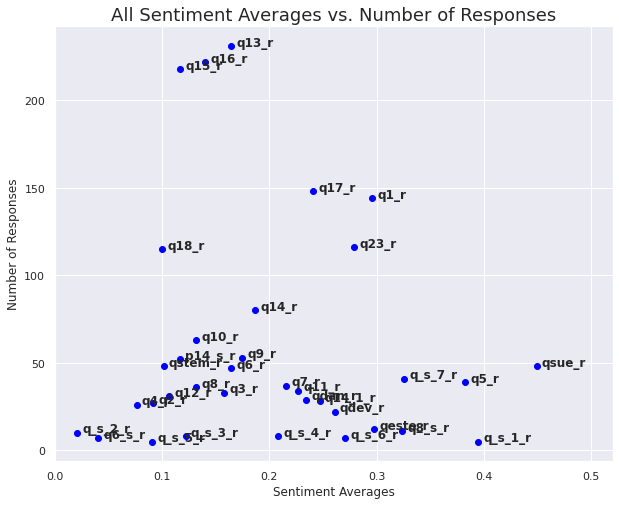

In [63]:
sns.set()
plt.rcParams['figure.figsize']=[10,8];

for name in avgs.columns:
 
  x=avgs[name][0]   #polarity values
  y=avgs[name][1]   #count of responses
  plt.scatter(x,y, color='blue');
  
  plt.text(x+.005, y+0.1, name, fontsize=12, fontweight='bold' ); # offset the name label
  
  # code to plot value with name
  # x_short=round(x,3)
  # y_short=round(y,3)
  # plt.text(x+0.005, y-0.006, (x_short,y_short), fontsize=10); # offset the name label
 
 # size plot frame
  plt.xlim(0, 0.52);

  plt.title('All Sentiment Averages vs. Number of Responses', fontsize=18);
  plt.xlabel('Sentiment Averages', fontsize=12);
  plt.ylabel('Number of Responses', fontsize=12);

####Averaging Response Sentiment over time by bootcamp

This takes all of the students who attended a bootcamp over the course of one year and averages their written responses per question.

In [64]:
nlp1417.shape

(49, 43)

In [65]:
#rsadf_c = rsadf copy for year and bootcamp vectorization purposes.
rsadf_c = rsadf.copy()

Create year column

In [66]:
rsadf_c['year'] = cdps['year'].copy()

In [67]:
rsadf_c['q1'] = cdps['q1'].copy()

Create new variable for preservation purposes.

In [68]:
rs1 = rsadf_c.copy()

We had to convert the "No Response"s in the data back into nan's because it's easier to find the mean of a column with nan's instead of strings, because pandas has a method for that.

In [69]:
rs1[rs1 == 'No Response'] = np.nan

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



This code block downcasts the type of columns to be floats so the nanmean function can be used to average them.

In [70]:
rs1['p14_s_r'] = rs1['p14_s_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q10_r'] = rs1['q10_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q11_r'] = rs1['q11_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q12_r'] = rs1['q12_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q13_r'] = rs1['q13_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q14_r'] = rs1['q14_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q14_1_r'] = rs1['q14_1_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q15_r'] = rs1['q15_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q16_r'] = rs1['q16_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q17_r'] = rs1['q17_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q18_r'] = rs1['q18_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q1_r'] = rs1['q1_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q23_r'] = rs1['q23_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q2_r'] = rs1['q2_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q3_r'] = rs1['q3_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q4_r'] = rs1['q4_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q5_r'] = rs1['q5_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q6_r'] = rs1['q6_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q6_s_r'] = rs1['q6_s_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q7_r'] = rs1['q7_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q8_r'] = rs1['q8_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q8_s_r'] = rs1['q8_s_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q9_r'] = rs1['q9_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q_s_1_r'] = rs1['q_s_1_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q_s_2_r'] = rs1['q_s_2_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q_s_3_r'] = rs1['q_s_3_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q_s_4_r'] = rs1['q_s_4_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q_s_5_r'] = rs1['q_s_5_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q_s_6_r'] = rs1['q_s_6_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['q_s_7_r'] = rs1['q_s_7_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['qdan_r'] = rs1['qdan_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['qdev_r'] = rs1['qdev_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['qeste_r'] = rs1['qeste_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['qstem_r'] = rs1['qstem_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
rs1['qsue_r'] = rs1['qsue_r'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')

In [71]:
rs1['year'] = rs1['year'].astype(int)

Convert q1 to bootcamp idenifier for easy groupings.

In [72]:
rs1 = rs1.rename(columns={'q1':'Bootcamp'})

In [73]:
#sa = Sentiment average by boot camp and year
sa = rs1.pivot_table(rs1, index=['Bootcamp', 'year'], aggfunc=np.nanmean, fill_value='-')

This is the resulting pivot table with all the response averages over time.

In [74]:
sa

p14_s_r        q10_r  ...    qstem_r    qsue_r
Bootcamp                  year                          ...                     
Data Science              2020          0         0.22  ...      -0.05      0.55
Digital Media             2018          -       0.2875  ...        0.1      0.45
                          2019 -0.0652778          0.1  ...   0.010625      0.65
                          2020   0.196429     0.189394  ...          -         -
Fullstack Web Development 2014          -         0.25  ...          -         -
                          2015          -     0.329167  ...          -         -
                          2016          -     0.369071  ...          -         -
                          2017          -     0.086067  ...       0.12         -
                          2018          -     0.181813  ...   0.219362  0.547292
                          2019  0.0785714     0.124797  ...   0.152274  0.489626
                          2020   0.143584    0.0603497  ... -0.0367674  0.416071
Internet of Things (IoT)  2020   0.209375    0.0325758  ...   0.129795  0.572222
Java+Android              2017          -     0.310714  ...          -         -
                          2018          -    0.0476587  ... -0.0496429  0.186429
                          2019   0.230648 -3.47222e-05  ...   0.418056  0.327972
                          2020  0.0231602   -0.0864583  ... -0.0333333     0.175
Microsoft .NET            2018          -            -  ...          -         -
                          2019          -            -  ...          -         -

[18 rows x 35 columns]

In [75]:
file_path = '/content/drive/My Drive/Team Lambda/Pivots/response-pivot.p'

In [76]:
pd.to_pickle(sa, open(file_path, 'wb'))

Export for use in individual notebook.



---



---



### Likert Responses Pivot

- begin with clean_data_post_likert (-2 to 2) scale
- convert likert to create pivot result

In [77]:
# dfpint = dataframe for pivot
dfpint=clean_data_post_likert.copy()

In [78]:
# replace index with Bootcamp column
dfpint=dfpint.rename(columns={'q1':'Bootcamp'})

In [79]:
# convert year to integer
dfpint['year'] = dfpint['year'].astype(int)

In [80]:
# convert each question so that pivot table function can operate on.
# note downcast to integer is ignored, it will make column float and
# any string found in column will be converted to 'NaN'
dfpint['q10'] = dfpint['q10'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q11'] = dfpint['q11'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q2'] = dfpint['q2'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q3'] = dfpint['q3'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q4'] = dfpint['q4'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q5'] = dfpint['q5'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q6'] = dfpint['q6'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q6_s'] = dfpint['q6_s'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q7'] = dfpint['q7'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q8'] = dfpint['q8'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q8_s'] = dfpint['q8_s'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q9'] = dfpint['q9'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['qdan'] = dfpint['qdan'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['qdev'] = dfpint['qdev'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['qstem'] = dfpint['qstem'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['qsue'] = dfpint['qsue'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q_s_1'] = dfpint['q_s_1'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q_s_2'] = dfpint['q_s_2'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q_s_3'] = dfpint['q_s_3'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q_s_4'] = dfpint['q_s_4'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q_s_5'] = dfpint['q_s_5'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['q_s_6'] = dfpint['q_s_6'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['qeste'] = dfpint['qeste'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['qkar'] = dfpint['qkar'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')
dfpint['qand'] = dfpint['qand'].apply(pd.to_numeric, errors = 'coerce', downcast = 'integer')

Averages likert responses per Bootcamp/year and question.

In [81]:
pvt=dfpint.pivot_table(dfpint, index=['Bootcamp', 'year'], aggfunc=np.nanmean, fill_value='-')
pvt

q10       q11  ...    qstem     qsue
Bootcamp                  year                      ...                  
Data Science              2020  1.666667  1.666667  ...  1.66667        2
Digital Media             2018  1.166667  1.333333  ...  1.83333  1.83333
                          2019  0.750000  0.947368  ...     1.25      1.8
                          2020  1.000000  1.000000  ...  1.33333      1.5
Fullstack Web Development 2014  0.100000  0.500000  ...        -        -
                          2015  0.937500  0.937500  ...        -        -
                          2016  1.166667  1.416667  ...        -        -
                          2017  0.615385  1.153846  ...     1.25      1.6
                          2018  0.925000  1.300000  ...  1.41026    1.825
                          2019  0.977778  1.200000  ...  1.58696  1.78261
                          2020  0.687500  1.125000  ...        1  1.84375
Internet of Things (IoT)  2020  1.285714  1.714286  ...  1.57143        2
Java+Android              2017  1.500000  2.000000  ...        2      1.5
                          2018  1.107143  1.357143  ...  1.42857  1.64286
                          2019  1.281250  1.468750  ...  1.65625  1.70968
                          2020  1.250000  1.500000  ...  1.66667  1.83333
Microsoft .NET            2018  2.000000  2.000000  ...        2        1
                          2019  2.000000  2.000000  ...      1.5        1

[18 rows x 25 columns]

###Categorical Response Pivots

These questions had responses that where Y/N. This was a different scaling that the Likert above which where (-2 to 2). This group also includes question 12 which was label encoded to categorical responses.

Q12: On average, how many hours per week have you spent, outside of the classroom, on this course?

In [82]:
dfp_cat=dfpint[['Bootcamp', 'q12', 'q1_1','year']]

In [83]:
#Question 12 pivot table
dfp_cat=dfp_cat.rename(columns={'q12':'Hours out of Class?'})
dfp_cat.pivot_table(index=['Bootcamp'],  values='year', columns='Hours out of Class?', aggfunc='count', fill_value='-', margins=True, margins_name=' | All years |', dropna=True,)

Hours out of Class?,10h - 15h,15h - 20h,greater than 20h,less than 10h,| All years |
Bootcamp,,,,,
Data Science,-,3,-,-,3
Digital Media,10,7,5,8,30
Fullstack Web Development,36,36,32,78,182
Internet of Things (IoT),-,1,4,2,7
Java+Android,15,19,21,19,74
Microsoft .NET,-,-,-,3,3
| All years |,61,66,62,110,299


Findings:

| Bootcamp | less than 10 | 10h - 15h | 15h_20h | greater than 20h |
|-|-|-|-|-|
| Data Science | - | - | 100% | - |
| Digital Media | 26% | 33% | 23% | 17% |
| Fullstack Web Development | 43% | 20% | 20% | 18% |
| Internet of Things (IoT) | 29% | - | 14% | 57% |
| Java+Android | 26% | 20% | 26% | 28% |
| Microsoft .Net | 100% | - | - | - |

Q1_1: On average, how likely are you to recommend this course?

In [84]:
#Question 1_1 pivot table
dfp_cat=dfp_cat.rename(columns={'q1_1':'likely recommend?'})
dfp_cat.pivot_table(index=['Bootcamp'],  values='year', columns='likely recommend?', aggfunc='count', fill_value='-', margins=True, margins_name=' | All years |', dropna=True,)

likely recommend?,No,No Response,Yes,| All years |
Bootcamp,,,,
Data Science,-,-,3,3
Digital Media,4,-,26,30
Fullstack Web Development,9,48,125,182
Internet of Things (IoT),-,-,7,7
Java+Android,3,3,68,74
Microsoft .NET,-,-,3,3
| All years |,16,51,232,299


Findings: 

| Bootcamp | percent Yes |
|-|-|
| Data Science | 100% |
| Digital Media | 87% |
| Fullstack Web Development | 87% * |
| Internet of Things (IoT) | 100% |
| Java+Android | 92% |
| Microsoft .Net | 100% |



* Note: web used 125/144 because No Responses were for first three years in which question was not asked in the survey.



---



---



---



###Averaging Written Responses and Plot

In [85]:
file_path = '/content/drive/My Drive/Team Lambda/Pivots/likert-pivot.p'

In [86]:
pd.to_pickle(pvt, open(file_path, 'wb'))

In [87]:
b=rsadf_c.copy()
b[b == 'No Response'] = np.nan

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Create Average written response plot for question 13

In [88]:
import plotly.express as px
#b=rsadf_c[rsadf_c['q13_r']!='No Response'] 
fig=px.scatter(b, x='year', y='q13_r', color='q1')
fig.show()

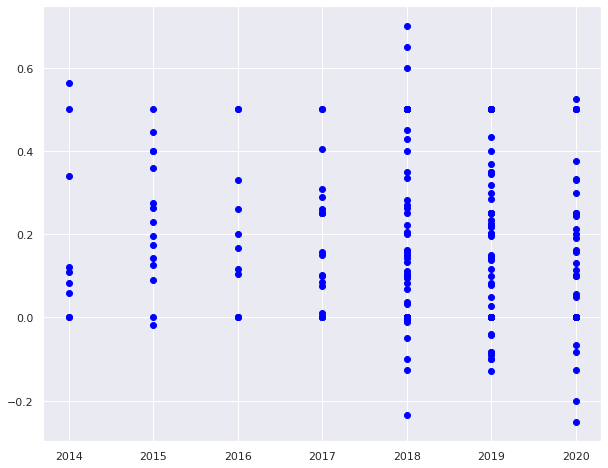

In [89]:

x=rsadf_c['year'][rsadf_c['q13_r']!='No Response']   #polarity values
y=rsadf_c['q13_r'][rsadf_c['q13_r']!= 'No Response'] #count of responses

plt.scatter(x,y, color='blue');

---
##Data Proccessing



### Hierarchical Clustering
CLUSTER SECTION - Main

####HCA prep

In [90]:
# DataFrame 'dfx' to be used to do Hier. cluster work
dfx=clean_data_post_likert.copy()

cut away response questions, leaving only Likert scale

In [91]:
columns = dfx.columns 
for column in columns:
  if column[-2:] == '_r':
    dfx.drop(column, axis=1, inplace=True)

In [92]:
dfx.columns

Index(['q1', 'q10', 'q11', 'q12', 'q14', 'q14_1', 'q14_1_1', 'q14_s', 'q1_1',
       'q2', 'q3', 'q4', 'q5', 'q6', 'q6_s', 'q7', 'q8', 'q8_s', 'q9', 'q_s_1',
       'q_s_2', 'q_s_3', 'q_s_4', 'q_s_5', 'q_s_6', 'qand', 'qdan', 'qdev',
       'qeste', 'qkar', 'qstem', 'qsue', 'year'],
      dtype='object')

Trim from dataframe;

*   All q14 questions ('q14', 'q14_1', 'q14_1_1', 'q14_s')
*   Bootcamp column, 'q1'
*   Year column, 'year'
*   Categorical columns: 'q12' & 'q1_1' (see EDA: Categorical Response Pivots)

In [93]:
dfx1=dfx[['q10','q11','q2','q3','q4','q5','q6','q6_s','q7','q8','q8_s','q9',
          'q_s_1', 'q_s_2', 'q_s_3', 'q_s_4','q_s_5','q_s_6','qand',
          'qdan','qdev','qeste','qkar','qstem','qsue']].copy()

In [94]:
dfx1.head()

,q10,q11,q2,q3,q4,q5,q6,q6_s,q7,q8,q8_s,q9,q_s_1,q_s_2,q_s_3,q_s_4,q_s_5,q_s_6,qand,qdan,qdev,qeste,qkar,qstem,qsue
0,1,1,2,2,2,2,1,No Response,2,2,No Response,1,No Response,No Response,No Response,No Response,No Response,No Response,No Response,2,2,No Response,No Response,1,2
1,0,0,1,1,2,2,1,No Response,1,0,No Response,1,No Response,No Response,No Response,No Response,No Response,No Response,No Response,1,0,No Response,No Response,2,2
2,0,1,2,1,1,1,1,No Response,1,1,No Response,-1,No Response,No Response,No Response,No Response,No Response,No Response,No Response,2,2,No Response,No Response,2,2
3,1,1,1,1,2,2,2,No Response,2,1,No Response,1,No Response,No Response,No Response,No Response,No Response,No Response,No Response,1,1,No Response,No Response,1,2
4,-1,1,2,1,2,2,1,No Response,1,0,No Response,-1,No Response,No Response,No Response,No Response,No Response,No Response,No Response,2,2,No Response,No Response,1,2


Replace No Reposes entries with nan and check

In [95]:
dfx1[dfx1 == 'No Response'] = np.nan
dfx1['q6_s'].unique()

array([nan, 2, 0, 1, -1], dtype=object)

Replaced 'nan' with column average

In [96]:
dfx1=dfx1.fillna(dfx1.mean())



---

####Original df

This section outlines the formatting for our original dataframe and our new datframe used for clustering question instead of student's responses.

columnS: questions;

rows: student responses

Dendrogram for Original dataframe.

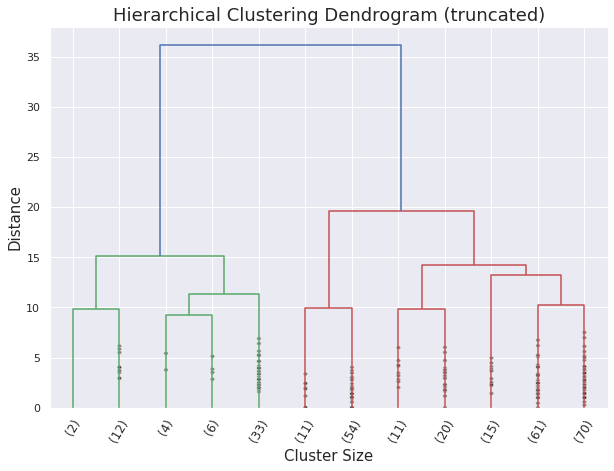

In [97]:
plt.figure(figsize=(10, 7));
z=shc.linkage(dfx1, method='ward');
dend = shc.dendrogram(z, truncate_mode='lastp', p=12, leaf_rotation=60., 
                      leaf_font_size=12., show_contracted=True, count_sort=True);

# where:
#               p > Parameter for truncate_mode
#   truncate_mode > Condenses dendrogram for readability
#   mode: 'lastp' > The last p non-singleton formed in the linkage are the only
#                    non-leaf nodes in the linkage; All other non-singleton 
#                    clusters are contracted into leaf nodes.
#   leaf_rotation > Specifies the angle (in degrees) to rotate the leaf labels.
#  leaf_font_size > Specifies the font size (in points) of the leaf labels.
# show_contracted > When 'True' the heights of non-singleton nodes contracted 
#                    into a leaf node are plotted as crosses along the link
#                    connecting that leaf node.Used when truncate_mode is used.
#      count_sort > For each node n, the order (visually from left to right)
#                    n's two descendent links are plotted is determined by this 
#                    parameter. When 'True' - the child with the minimum
#                    number of original objects in its cluster is plotted first.

plt.title("Hierarchical Clustering Dendrogram (truncated)", fontsize=18) ;
plt.xlabel('Cluster Size', fontsize=15);
plt.ylabel('Distance', fontsize=15);


Using Sklearn Clustering

In [98]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
clusterNums = pd.Series(cluster.fit_predict(dfx1))

Cluster base (whole data frame - question 14)

In [99]:
dfx1_cnums=dfx1.copy()
dfx1_cnums['clusterNums']=clusterNums

In [100]:
dfx1_cnums.pivot_table(dfx1_cnums, index=['clusterNums'], aggfunc=np.nanmean, fill_value='-')

,q10,q11,q2,q3,q4,q5,q6,q6_s,q7,q8,q8_s,q9,q_s_1,q_s_2,q_s_3,q_s_4,q_s_5,q_s_6,qand,qdan,qdev,qeste,qkar,qstem,qsue
clusterNums,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.280702,0.350877,0.877193,0.385965,0.591521,0.754386,0.409262,1.179459,0.987691,0.167555,0.466009,-0.351056,1.465472,0.040670,0.736842,1.385202,0.993281,1.357822,1.654971,1.145537,1.292032,1.489111,1.827485,0.817417,1.538970
1,0.988454,1.268276,1.303430,1.258131,1.244288,1.754882,1.553078,1.375942,1.688240,1.286649,0.688559,1.061975,1.647674,0.167565,0.965331,1.538688,1.116721,1.543550,1.670433,1.173009,1.553986,1.578317,1.835217,1.502757,1.784292
2,1.953846,1.953846,1.907692,1.892308,1.791966,1.984615,1.762566,1.448077,1.863275,1.787481,0.878846,1.969231,1.666448,0.239860,1.116084,1.595318,1.275286,1.601923,1.666667,1.558491,1.695085,1.613528,1.833333,1.812841,1.898235


In [101]:
#add another column of averages on to frame which represents mean of responses
dfx1_cnums['response_mean']=dfx1_cnums.mean(axis=1)

In [102]:
dfx1_cnums.head()

,q10,q11,q2,q3,q4,q5,q6,q6_s,q7,q8,q8_s,q9,q_s_1,q_s_2,q_s_3,q_s_4,q_s_5,q_s_6,qand,qdan,qdev,qeste,qkar,qstem,qsue,clusterNums,response_mean
0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.354167,2.0,2.0,0.6875,1.0,1.617021,0.159091,0.954545,1.521739,1.12766,1.520833,1.666667,2.0,2.0,1.568966,1.833333,1.0,2.0,1,1.461982
1,0.0,0.0,1.0,1.0,2.0,2.0,1.0,1.354167,1.0,0.0,0.6875,1.0,1.617021,0.159091,0.954545,1.521739,1.12766,1.520833,1.666667,1.0,0.0,1.568966,1.833333,2.0,2.0,0,1.077366
2,0.0,1.0,2.0,1.0,1.0,1.0,1.0,1.354167,1.0,1.0,0.6875,-1.0,1.617021,0.159091,0.954545,1.521739,1.12766,1.520833,1.666667,2.0,2.0,1.568966,1.833333,2.0,2.0,0,1.154289
3,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.354167,2.0,1.0,0.6875,1.0,1.617021,0.159091,0.954545,1.521739,1.12766,1.520833,1.666667,1.0,1.0,1.568966,1.833333,1.0,2.0,1,1.308135
4,-1.0,1.0,2.0,1.0,2.0,2.0,1.0,1.354167,1.0,0.0,0.6875,-1.0,1.617021,0.159091,0.954545,1.521739,1.12766,1.520833,1.666667,2.0,2.0,1.568966,1.833333,1.0,2.0,0,1.115828


In [103]:
df_meanxx=pd.concat([dfx1_cnums['response_mean'],dfx1_cnums['clusterNums']], axis=1)

This is the mean of the response dataframe above with requested number of clusters (3).

In [104]:
df_meanxx.pivot_table(df_meanxx, index=['clusterNums'])

,response_mean
clusterNums,
0,0.818576
1,1.328825
2,1.644879




---


####Transpose the dataframe

columnS: student responses;

rows: questions

In [105]:
try_t=dfx1.copy()

Transposing the original dataframe so that we can see how the questions scored given the students' responses.

In [106]:
t_try=try_t.T
t_try.shape

(25, 299)

Now we see the questions are in the rows and the students' responses are in the columns.

In [107]:
t_try.tail(25)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298
q10,1.000000,0.000000,0.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,0.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,...,-1.000000,-1.000000,2.000000,1.000000,1.000000,0.000000,2.000000,1.000000,2.000000,0.000000,2.000000,1.000000,0.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,-1.000000,2.000000,2.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,1.000000
q11,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,1.000000,1.000000,2.000000,1.242424,2.000000,2.000000,2.000000,2.000000,...,0.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,-1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,0.000000,1.000000,0.000000,2.000000,0.000000,-2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-2.000000,1.000000,1.000000,0.000000,1.000000,1.000000
q2,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,-2.000000,2.000000,-1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,0.000000,1.000000,2.000000,...,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,-2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,-1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
q3,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.229730,2.000000,1.000000,1.000000,0.000000,0.000000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,...,-1.000000,0.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.229730,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-2.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000
q4,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,2.000000,0.000000,2.000000,-1.000000,1.000000,2.000000,...,0.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,0.000000,1.000000,2.000000,2.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,-2.000000,-1.000000,1.000000,-1.000000,1.238908,2.000000,1.000000,-2.000000,1.000000,1.000000,1.000000,1.238908,1.238908,-2.000000,0.000000,2.000000,1.238908,2.000000,0.000000
q5,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.00000

Confirming shape

In [108]:
t_try.shape

(25, 299)

Dendrogram for the Transposed dataframe

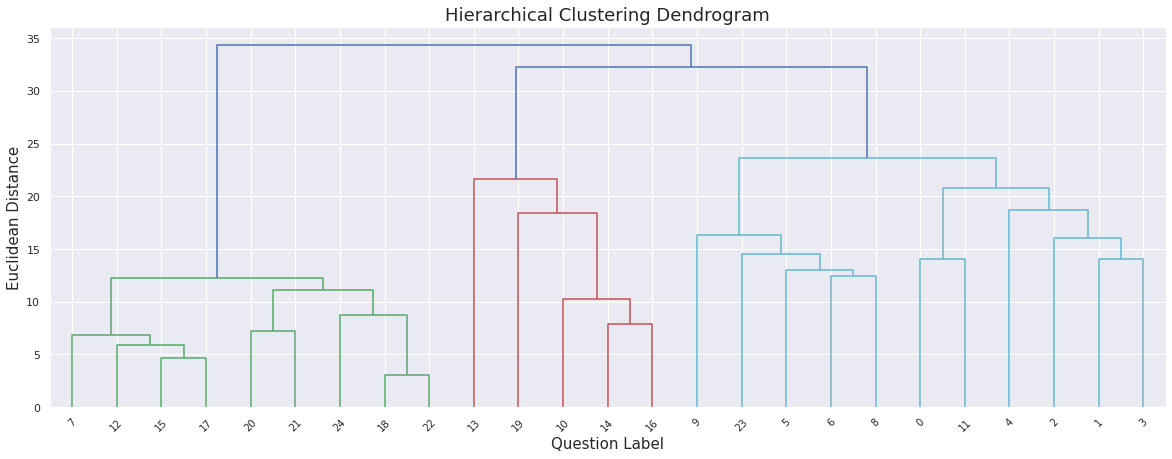

In [109]:
plt.figure(figsize=(20, 7));
z=shc.linkage(t_try, method='ward');

dend = shc.dendrogram(z,  count_sort=True);

# where:
#  count_sort > For each node n, the order (visually from left to right)
#               n's two descendent links are plotted is determined by this 
#               parameter. When 'True' - the child with the minimum
#               number of original objects in its cluster is plotted first.

plt.title("Hierarchical Clustering Dendrogram", fontsize=18) ;
plt.xlabel('Question Label', fontsize=15);
plt.ylabel('Euclidean Distance', fontsize=15);


After loading the transposed dataframe into a plot, we found 5 unique clusters. After further examination some of these clusters matched up (not exactly) but closely to the categories that we had produced originally.

Using Sklearn Clustering

In [110]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward',)  
clusterNumsT = pd.Series(cluster.fit_predict(t_try), index=t_try.index)

In [111]:
t_try.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298
q10,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,2.0,2.0,0.0,1.0,0.0,1.0,1.0,2.00000,2.0,2.0,1.0,0.0,0.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,1.0,2.0,1.000000,2.0,2.0,2.0,2.0,...,-1.0,-1.0,2.0,1.0,1.0,0.0,2.0,1.0,2.0,0.0,2.0,1.0,0.0,2.0,0.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,0.00000,0.0,-1.0,2.000000,2.0,0.0,0.0,2.0,1.0,1.0,0.000000,0.000000,-2.0,0.0,0.0,0.000000,0.0,1.0
q11,1.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.00000,2.0,2.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,1.0,2.0,1.242424,2.0,2.0,2.0,2.0,...,0.0,1.0,2.0,2.0,1.0,2.0,2.0,-1.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,0.0,2.0,1.0,2.00000,0.0,1.0,0.000000,2.0,0.0,-2.0,1.0,1.0,1.0,1.000000,0.000000,-2.0,1.0,1.0,0.000000,1.0,1.0
q2,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1.00000,2.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,-2.0,2.0,-1.0,1.0,2.0,1.0,2.0,1.000000,2.0,0.0,1.0,2.0,...,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,0.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,-2.0,1.00000,1.0,1.0,2.000000,2.0,1.0,2.0,2.0,1.0,1.0,1.000000,-1.000000,2.0,1.0,1.0,1.000000,1.0,1.0
q3,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.22973,2.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,2.0,1.000000,2.0,1.0,1.0,2.0,...,-1.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,1.22973,1.0,1.0,2.000000,2.0,1.0,0.0,1.0,1.0,1.0,1.000000,0.000000,-2.0,-1.0,0.0,-1.000000,1.0,0.0
q4,2.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,0.0,2.0,1.0,2.0,2.0,1.00000,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,2.0,0.000000,2.0,-1.0,1.0,2.0,...,0.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,0.0,1.0,2.0,2.0,1.0,1.0,-1.0,0.0,0.0,-2.0,-1.00000,1.0,-1.0,1.238908,2.0,1.0,-2.0,1.0,1.0,1.0,1.238908,1.238908,-2.0,0.0,2.0,1.238908,2.0,0.0


In [112]:
dfx1_cnumsT=t_try.copy()

In [113]:
#add another column of average across columns (students)
dfx1_cnumsT['question_mean']=dfx1_cnumsT.mean(axis=1)

In [114]:
dfx1_cnumsT['clusterNumsT']=clusterNumsT

In [115]:
df_mean=pd.concat([dfx1_cnumsT['question_mean'],dfx1_cnumsT['clusterNumsT']], axis=1)

Want to know the question_mean by the results from the Dendrogram. To do this, need the Dendrogram clustering pattern, H-cluster.

In [116]:
H_clust=[4,4,4,4,4,3,3,0,3,3,2,4,0,2,2,0,2,0,1,2,1,1,1,3,1]

In [117]:
dfx1_cnumsT['H_cluster']=H_clust

In [118]:
dfx1_cnumsT.head(25)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,question_mean,clusterNumsT,H_cluster
q10,1.000000,0.000000,0.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,0.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,1.000000,0.000000,2.000000,1.000000,2.000000,0.000000,2.000000,1.000000,0.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,-1.000000,2.000000,2.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.956376,0,4
q11,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,1.000000,1.000000,2.000000,1.242424,2.000000,2.000000,2.000000,2.000000,...,2.000000,1.000000,2.000000,2.000000,-1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,0.000000,1.000000,0.000000,2.000000,0.000000,-2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.242424,0,4
q2,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,-2.000000,2.000000,-1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,0.000000,1.000000,2.000000,...,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,-2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,-1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.353535,0,4
q3,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.229730,2.000000,1.000000,1.000000,0.000000,0.000000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,...,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.229730,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-2.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.229730,0,4
q4,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,2.000000,0.000000,2.000000,-1.000000,1.000000,2.000000,...,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,0.000000,1.000000,2.000000,2.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,-2.000000,-1.000000,1.000000,-1.000000,1.238908,2.000000,1.000000,-2.000000,1.000000,1.000000,1.000000,1.238908,1.238908,-2.000000,0.000000,2.000000,1.238908,2.000000,0.000000,1.238908,0,4
q5,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,0

In [119]:
# #transposed frames/averages per cluster
# df_mean.pivot_table(df_mean, index=['clusterNums'])

In [120]:
df_meanH=pd.concat([dfx1_cnumsT['question_mean'],dfx1_cnumsT['H_cluster']], axis=1)

In [121]:
#transposed frame with H-cluster
df_meanH.pivot_table(df_meanH, index=['H_cluster'])

,question_mean
H_cluster,
0,1.503440
1,1.673197
2,0.836074
3,1.441821
4,1.168467


Findings: The transposed dataframe focuses on the how the questions score based on the students' responses. From the Dendrogram we saw five distinct groupings, similar to the five categories we initially assigned during EDA review. After running the mean, we see the rankings listed from (most favorable to least favorable.) 

Note: all the averages were positive.

| H_cluster | Question grouping | Ranking |
|-|-|-|
| 1 | qand, qdev, qeste, qkar, qsue | most favorable |
| 0 | q6_s,q_s_1, q_s_4, q_s_6, | next favorable |
| 3 | q5, q6, q7,q8, qstem | mid favorable |
| 4 | q10, q11, q2, q3, q4, q9 | less favorable |
| 2 | q8_s, q_s_2, q_s_3, q_s_5, qdan | least favorable |

 

Given this, the last category (least favorable) could point to an area for improvement.

Questions legend ----------

least favorable group: (Cluster 2)
*   **q8_s**: "The instructor's course presentations were organized."
*   **q_s_2**: "The textbook helped me to learn."
*   **q_s_3**: "Homework assignments helped me better understand the course material."
*   **q_s_5**: "The instructor evaluated my learning based on course material presented and course requirements."
*   **qdan**: "I had a good experience with my Career Coach (Daniel).** (Note: there were no entries for this question in later years therefore may be an anomally.)

less favorable group: (Cluster 4)
*  **q9**: 'I am satisfied with the format of the instruction'
*  **q10**: 'The pace of the course material was conducive to my learning.'
*  **q11**: 'The level of the course material, was conducive to my learning'
*  **q2**: 'I understand the goals and objectives of this course when it began'
*  **q3**: 'The goals and objectives of this course, as I understand them are met at this time.'
*  **q4**: 'The requirements and grading system for the course were clear.'

mid favorable group: (Cluster 3)
*  **q5**: 'My instructor treated me with respect.'
*  **q6**: 'The instructors were available to help when asked.'
*  **q7**: 'The instructors were knowledgeable about the course material.'
*  **q8**: 'The instructors were organized and prepared.'
*  **qstem**: 'The STEMulus Center provided an effective learning environment.'

next favorable group: (Cluster 0)
*  **q_s_1**: 'I felt free to ask questions in the course.'
*  **q_s_4**: 'The instructor was willing to work with me outside of the class.'
*  **q_s_6**: 'I have become more competent in this area due to this course.'
*  **q6_s**: 'The instructor answered my questions when I asked them.'

most favorable group: (Cluster 1)
*  **qand**: 'I had a good experience with the Senior Program Manager (Andrea).'
*  **qdev**: 'I had a good experience with the Program Manager (Devonna).'
*  **qeste**: 'I had a good experience witht the Employer Relations Manager (Esteban).'
*  **qkar**: 'I had a good experience with my Student Success Specialst (Karen).'
*  **qsue**: 'I had a good experience with my Bootcamp Success Manager (Sue).'


---
####Q14 Compare


From EDA analysis: remove question 14 from main df


In [122]:
q14_df=clean_data_post_likert[['q14','q14_r', 'q14_s', 'q14_1', 'q14_r', 'p14_s_r','q14_1_1', 'q14_1_r']].copy()

In [123]:
dfx14=q14_df['q14'].copy()

In [124]:
dfx14_df=pd.DataFrame(dfx14, columns=['q14'])

Translate Q14 responses: Important

Q14 was "Did you have any concerns before entering bootcamp? To match the scaling of the other questions,


*   'No' answer > is a positive outcome; therefore modelled as '1'
*   'Yes' answer > is a negative outcome; therefore modelled as '-1'
*   'No Reponse' > modelled as '0' >> needed to match the shape of the ClusterNums result coming from the original df Dendogram. Will be removed before any averaging is done to avoid skewing the results.








In [125]:
dfx14_df.replace('No', 1, inplace=True)
dfx14_df.replace('Yes',-1, inplace=True)
dfx14_df.replace('No Response',0, inplace=True)

In [126]:
dfx14_df['q14'].unique()

array([ 1, -1,  0])

Place clusterNums into q14 (df)

In [127]:
dfx14_df['clusterNums']=clusterNums

In [128]:
dfx14_df=dfx14_df[dfx14_df['q14']!=0]

Q14 Result/Findings

In [129]:
dfx14_df.pivot_table(dfx14_df, index=['clusterNums'], aggfunc=np.nanmean, fill_value='-')

,q14
clusterNums,
0,0.111111
1,-0.216495
2,0.000000


Findings when compared to q14: Overall, generally positive outcomes.



1.   q10 & q9 are the only ones that showed as slightly negative (largest range between positive and negative)
2.   appears to be three categories of outcome:



|Cluster|	Disposition (in)|	Disposition (out)|
|-|-|-|
|0|	most positive	|least positive|
|1|	least positive|	second most positive|
|2|	mid positivie|	most positive|

What does this mean?


*   the student "not having concerns" (i.e. most positive expectation), their outcome was the least positive;
*   the student "having concerns" (i.e. most negative expectation), their outcome was less positive.
*   the student "that had niether" (i.e. no expectation), had the most positive outcome.


---
####Q14_r Compare


Q14_r Prep

In [130]:
dfx14r=rsadf['q14_r'].copy()

Make Series a Dataframe

In [131]:
dfx14r_df=dfx14r.copy()
dfx14r_df=pd.DataFrame(dfx14r_df, columns=['q14_r'])

Replace No Response

In [132]:
dfx14r_df.replace('No Response',0, inplace=True)

Apply Cluster frame

In [133]:
dfx14r_df['clusterNums']=clusterNums

Removed zero valued responses ???

In [134]:
dfx14r_df=dfx14r_df[dfx14r_df['q14_r']!=0]

Q14_r Results/Findings

In [135]:
# q14_r > written response to did you have any concerns before?
dfx14r_df.pivot_table(dfx14r_df, index=['clusterNums'], aggfunc=np.nanmean, fill_value='-')

,q14_r
clusterNums,
0,0.249003
1,0.226044
2,0.230487


****words needed*****



---



---



###WORD CLOUD

*   gather the responses (raw)
*   remove stop words
*   create word clouds per bootcamp



In [136]:
# need to adjust this definition in main book (from above)
clean_data.head(2)

# grab just prior to sementiation, just response questions
wc_df=clean_data.copy()

rename Bootcamp into df

In [137]:
#add bootcamp onto wc
wc_df = wc_df.rename(columns={'q1':'Bootcamp'})

In [138]:
#set aside Bootcamp column
wc_boot=wc_df['Bootcamp']

In [139]:
#remove the year from the dataframe 
wc_ny=wc_df.drop(['year'], axis=1)

In [140]:
#this block drops unwanted columns from wc_df (i.e. retain only response questions) -- want all columns because some _r are empty
columns = wc_ny.columns 
for column in columns:
  if column[-2:] != '_r':
     wc_ny.drop(column, axis=1, inplace=True)

In [141]:
# put Bootcamps back into df
wc_ny['Bootcamp']=wc_boot

In [142]:
# one package of all words in dataframe > returns a Series
wc_full_s=wc_ny.apply(lambda x: x.str.split(expand=True).stack()).stack()

In [143]:
# convert to a list
wc_full_lst=list(wc_full_s)

In [144]:
# Make bootcamp corpora
wc_web=wc_ny.loc[wc_ny['Bootcamp'] == 'Fullstack Web Development'] 
wc_ja=wc_ny.loc[wc_ny['Bootcamp'] == 'Java+Android']
wc_dm=wc_ny.loc[wc_ny['Bootcamp'] == 'Digital Media']
wc_net=wc_ny.loc[wc_ny['Bootcamp'] == 'Microsoft .NET']
wc_iot=wc_ny.loc[wc_ny['Bootcamp'] == 'Internet of Things (IoT)']
wc_ds=wc_ny.loc[wc_ny['Bootcamp'] == 'Data Science']

In [145]:
# *.apply method return a Series ... need a list
wc_web_lst=list(wc_web.apply(lambda x: x.str.split(expand=True).stack()).stack())
wc_ja_lst=list(wc_ja.apply(lambda x: x.str.split(expand=True).stack()).stack())
wc_dm_lst=list(wc_dm.apply(lambda x: x.str.split(expand=True).stack()).stack())
wc_net_lst=list(wc_net.apply(lambda x: x.str.split(expand=True).stack()).stack())
wc_iot_lst=list(wc_iot.apply(lambda x: x.str.split(expand=True).stack()).stack())
wc_ds_lst=list(wc_ds.apply(lambda x: x.str.split(expand=True).stack()).stack())

#### All Bootcamps Helmet

All responses for all bootcamps: DDC

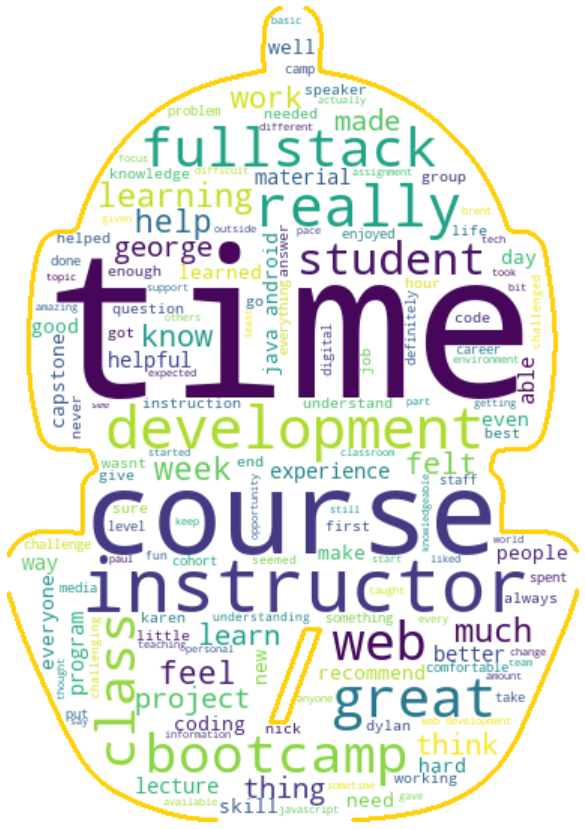

In [146]:
ds_helmet=ddc_wordcloud(wc_full_lst, 150)
plt.figure(figsize=(25,15))
plt.imshow(ds_helmet, interpolation='bilinear')
plt.axis('off')
plt.show()

Data Science Helmet

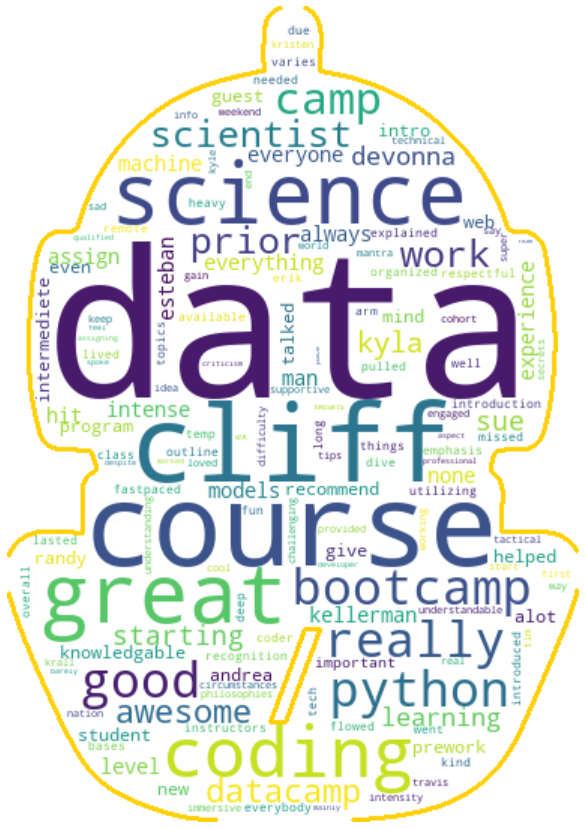

In [147]:
ds_helmet=ddc_wordcloud(wc_ds_lst,150)
plt.figure(figsize=(25,15))
plt.imshow(ds_helmet, interpolation='bilinear')
plt.axis('off')
plt.show()

####IoT Helmet

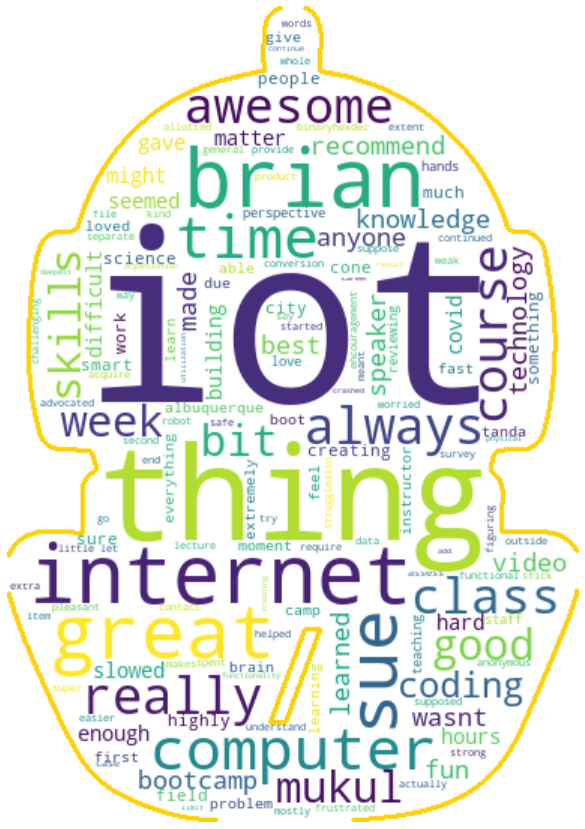

In [148]:
iot_helmet=ddc_wordcloud(wc_iot_lst,150)
plt.figure(figsize=(25,15))
plt.imshow(iot_helmet, interpolation='bilinear')
plt.axis('off')
plt.show()

####Microsoft .NET Helmet

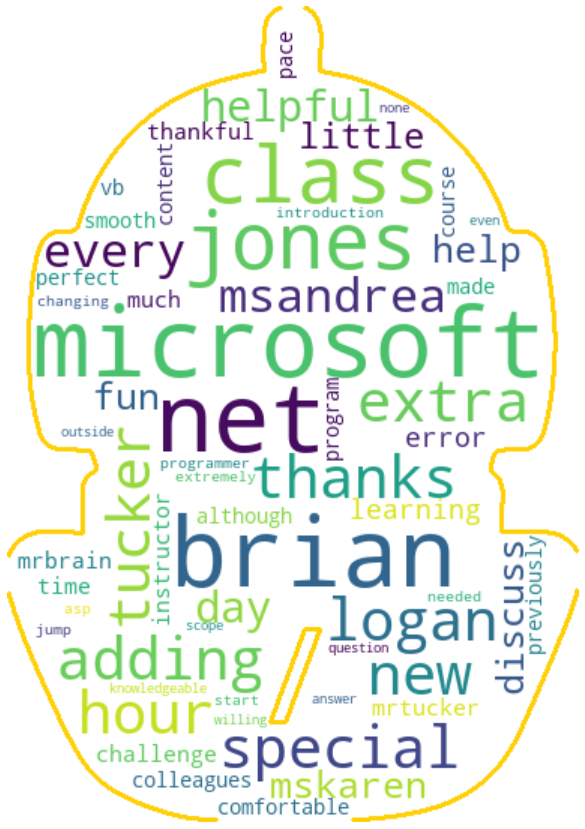

In [149]:
net_helmet=ddc_wordcloud(wc_net_lst,150)
plt.figure(figsize=(25,15))
plt.imshow(net_helmet, interpolation='bilinear')
plt.axis('off')
plt.show()

####Digital Media Helmet

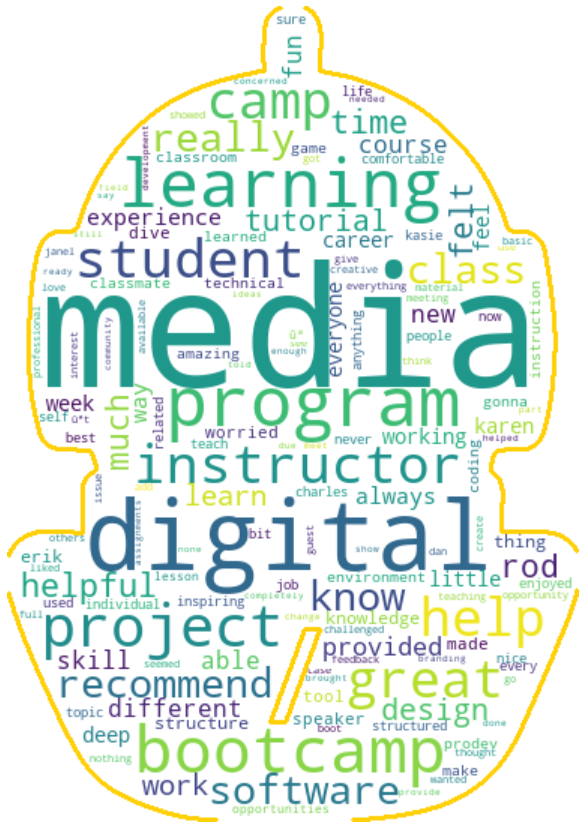

In [150]:
dm_helmet=ddc_wordcloud(wc_dm_lst,150)
plt.figure(figsize=(25,15))
plt.imshow(dm_helmet, interpolation='bilinear')
plt.axis('off')
plt.show()

####Java & Android Helmet

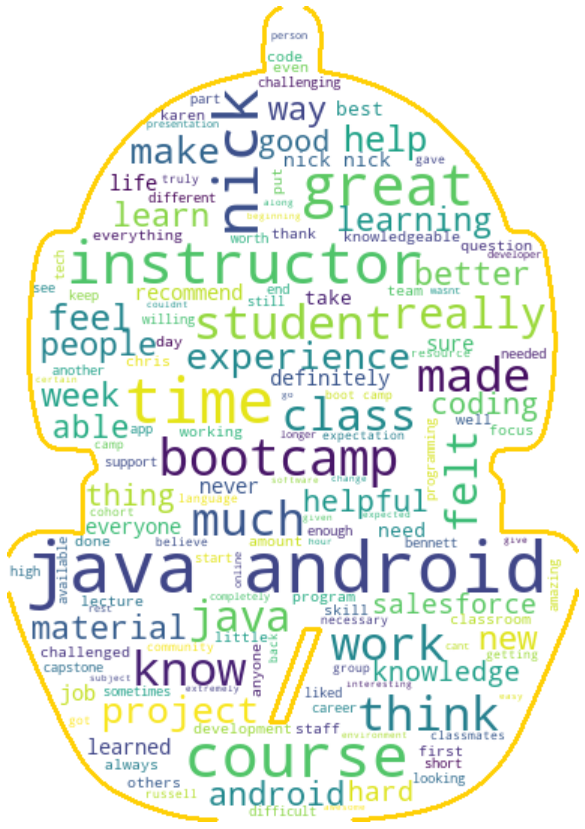

In [151]:
ja_helmet=ddc_wordcloud(wc_ja_lst,150)
plt.figure(figsize=(25,15))
plt.imshow(ja_helmet, interpolation='bilinear')
plt.axis('off')
plt.show()

####Fullstack Web Development Helmet

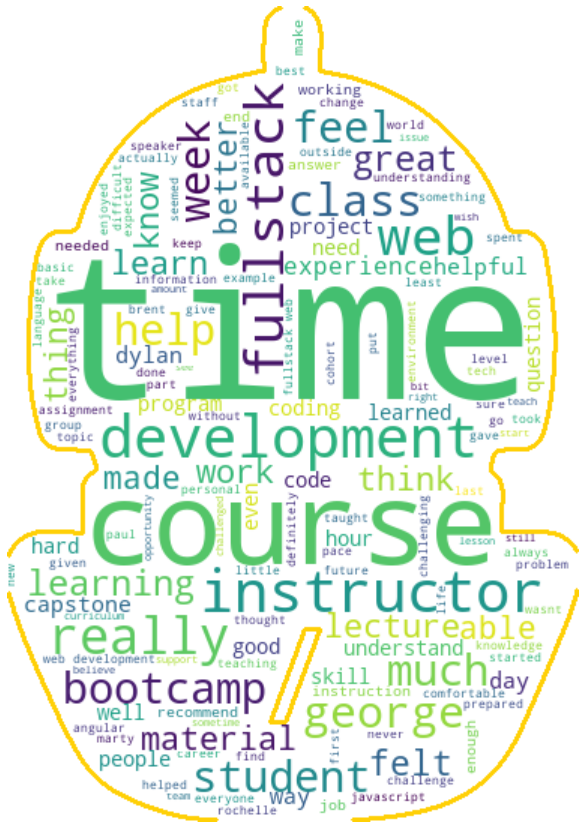

In [152]:
web_helmet=ddc_wordcloud(wc_web_lst,150)
plt.figure(figsize=(25,15))
plt.imshow(web_helmet, interpolation='bilinear')
plt.axis('off')
plt.show()



---



---



---



##Data Visualization

#### Combination of tables

We need to concatenate the pivot tables to produce plots that compate likert andwritten responses.

In [153]:
comb = pd.concat([pvt,sa], axis=1, join='outer')

In [154]:
comb = comb.reset_index()

##### q10

Producing a question comparison will entail grouping the two categories together and adding the bootcamp and year.

In [155]:
q10 = comb[['Bootcamp','year','q10', 'q10_r']].copy()
q10['q10'] = q10['q10']/2
q10

,Bootcamp,year,q10,q10_r
0,Data Science,2020,0.833333,0.22
1,Digital Media,2018,0.583333,0.2875
2,Digital Media,2019,0.375000,0.1
3,Digital Media,2020,0.500000,0.189394
4,Fullstack Web Development,2014,0.050000,0.25
5,Fullstack Web Development,2015,0.468750,0.329167
6,Fullstack Web Development,2016,0.583333,0.369071
7,Fullstack Web Development,2017,0.307692,0.086067
8,Fullstack Web Development,2018,0.462500,0.181813
9,Fullstack Web Development,2019,0.488889,0.124797


We then have to melt the 2 separate questions together into the same column, and use another column to identify which question they are.

In [156]:
q10_1 = q10.melt(id_vars=['Bootcamp', 'year'], var_name='Question', value_name='Score')

Now for a plot.

In [157]:
fig= px.line(q10_1, x='year', y='Score', color='Bootcamp', facet_col='Question', title='The pace of the course was conducive to my learning.')
fig.update_yaxes(range=[-1, 1.05])
fig.update_layout(margin=dict(
        l=100,
        r=100,
        b=80,
        t=100,
        pad=1
        ))
fig.show()

##### q9

Repeat grouping step for question 9 likert and written responses.

In [158]:
q9 = comb[['Bootcamp','year','q9', 'q9_r']].copy()
q9['q9'] = q9['q9']/2
q9

,Bootcamp,year,q9,q9_r
0,Data Science,2020,0.833333,0.218519
1,Digital Media,2018,0.583333,0.0288462
2,Digital Media,2019,0.300000,0.15
3,Digital Media,2020,0.500000,0.179545
4,Fullstack Web Development,2014,-0.125000,0.05
5,Fullstack Web Development,2015,0.375000,0.101607
6,Fullstack Web Development,2016,0.541667,0.566667
7,Fullstack Web Development,2017,0.346154,0.144444
8,Fullstack Web Development,2018,0.300000,0.140202
9,Fullstack Web Development,2019,0.533333,0.227215


Melt question 9 table.

In [159]:
q9_1 = q9.melt(id_vars=['Bootcamp', 'year'], var_name='Question', value_name='Score')

Now for a plot.

In [160]:
fig= px.line(q9_1, x='year', y='Score', color='Bootcamp', facet_col='Question', title='I am satisfied with the format of the instruction.')
fig.update_yaxes(range=[-1, 1.05])
fig.update_layout(margin=dict(
        l=100,
        r=100,
        b=80,
        t=100,
        pad=1
        ))
fig.show()

###Compartmentalize

Create a list of the names of groupings of questions.

In [161]:
question_lists = [ddcenter_questions, prereq_questions, curriculum_questions, outcome_questions, instructor_questions, likert_scale_questions,response_questions]

Produce data frames that contain all the information from each of the bootcamps.

In [162]:
ddcenter_table = clean_data_post_likert.loc[:,ddcenter_questions]
prereq_table = clean_data_post_likert.loc[:,prereq_questions]
curriculum_table = clean_data_post_likert.loc[:,curriculum_questions]
outcome_table = clean_data_post_likert.loc[:,outcome_questions]
instructor_table = clean_data_post_likert.loc[:,instructor_questions]

###Likert Only

Take the data frames created for each bootcamp and produce data frames containing only answers from Likert style questions.

In [163]:
def likert_only(data_frame):
  """Produce a dataframe with only likert questions."""
  
  placeholder = {}
  for column in data_frame.columns:
    if column in likert_scale_questions:
      placeholder[column] = data_frame[column]
  return pd.DataFrame.from_dict(placeholder)

In [164]:
ddcenter_likert = likert_only(ddcenter_table)
prereq_likert = likert_only(prereq_table)
curriculum_likert = likert_only(curriculum_table)
outcome_likert = likert_only(outcome_table)
instructor_likert = likert_only(instructor_table)

####Average Likert

Produce and array with the average and standard deviation for each bootcamp.

In [165]:
def total_average_of(data_frame):
  """Average all numbers found in a dataframe."""
  
  count = 0
  points = []
  for column in data_frame.columns:
    for item in data_frame[column]:
      if item == 'No Response':
        continue
      else:
        count += 1
        points.append(int(item))
  if count == 0:
    return -2, 0
  return sum(points) / count, statistics.pstdev(points)

In [166]:
catagory_likerts, catagory_deviation = zip(*[total_average_of(ddcenter_likert),
                    total_average_of(prereq_likert),
                    total_average_of(curriculum_likert),
                    total_average_of(outcome_likert),
                    total_average_of(instructor_likert)])

####Likert By year

Produce variables with a list of the likert scores by year.

In [167]:
def by_year(data_frame):
  """Produce averages of each years likert scores on a scale from 0 to 4"""
  
  averages = []
  starndard_deviations = []
  averages.append(total_average_of(data_frame[clean_data_post_likert['year'] == 2014])[0] + 2)
  averages.append(total_average_of(data_frame[clean_data_post_likert['year'] == 2015])[0] + 2)
  averages.append(total_average_of(data_frame[clean_data_post_likert['year'] == 2016])[0] + 2)
  averages.append(total_average_of(data_frame[clean_data_post_likert['year'] == 2017])[0] + 2)
  averages.append(total_average_of(data_frame[clean_data_post_likert['year'] == 2018])[0] + 2)
  averages.append(total_average_of(data_frame[clean_data_post_likert['year'] == 2019])[0] + 2)
  averages.append(total_average_of(data_frame[clean_data_post_likert['year'] == 2020])[0] + 2)

  starndard_deviations.append(total_average_of(data_frame[clean_data_post_likert['year'] == 2014])[1])
  starndard_deviations.append(total_average_of(data_frame[clean_data_post_likert['year'] == 2015])[1])
  starndard_deviations.append(total_average_of(data_frame[clean_data_post_likert['year'] == 2016])[1])
  starndard_deviations.append(total_average_of(data_frame[clean_data_post_likert['year'] == 2017])[1])
  starndard_deviations.append(total_average_of(data_frame[clean_data_post_likert['year'] == 2018])[1])
  starndard_deviations.append(total_average_of(data_frame[clean_data_post_likert['year'] == 2019])[1])
  starndard_deviations.append(total_average_of(data_frame[clean_data_post_likert['year'] == 2020])[1])

  return averages, starndard_deviations

In [168]:
ddcenter_likert_year, ddcenter_deviations = by_year(ddcenter_likert)
prereq_likert_year, prereq_deviations = by_year(prereq_likert)
curriculum_likert_year, curriculum_deviations = by_year(curriculum_likert)
outcome_likert_year, outcome_deviations = by_year(outcome_likert)
instructor_likert_year, instructor_deviations = by_year(instructor_likert)

###Response Percentages

Produce an array that has each bootcamp’s percentage of written responses compared to likert responses. 

In [169]:
def find_percentage_of(column_likert, column_response):
  """Produce percentage of responces in column."""

  num_questions = 0
  num_responses = 0
  for idx, item in enumerate(column_likert):
    if item == 'No Response':
      continue
    else:
      num_questions += 1
      if column_response[idx] == 'No Response':
        continue
      else:
        num_responses += 1
  return num_responses / num_questions

In [170]:
def find_percentage(list_likert, list_response, table):
  """Find the average percentage of likert responces that had a long responce as well"""

  sum = 0
  for idx in range(len(list_likert)):
    sum += find_percentage_of(table[list_likert[idx]], table[list_response[idx]])
  return sum / len(list_likert)

In [171]:
ddcenter_frequency = find_percentage(['qdan', 'qdev', 'qeste', 'qsue'],
                                        ['qdan_r', 'qdev_r', 'qeste_r', 'qsue_r'],
                                        ddcenter_table)
prereq_frequency = find_percentage(['q14_1','q14','q14_1_1','q14_s','q2','q4'],
                                      ['q14_r','q14_r','q14_r','q14_r','q2_r','q4_r'],
                                      prereq_table)
curriculum_frequency = find_percentage(['q10','q_s_2','q_s_3','q11','q12','q9'],
                                          ['q10_r','q_s_2_r','q_s_3_r','q11_r','q12_r','q9_r'],
                                          curriculum_table)
outcome_frequency = find_percentage(['q1', 'q1_1','q3'],
                                       ['q1_r', 'q1_r','q3_r'],
                                       outcome_table)
instructor_frequency = find_percentage(['q_s_1', 'q_s_4', 'q_s_5', 'q5', 'q6','q6_s','q7','q8','q8_s'],
                                          ['q_s_1_r', 'q_s_4_r', 'q5_r', 'q5_r', 'q6_r', 'q6_s_r','q7_r','q8_r','q8_r'],
                                          instructor_table)

In [172]:
catagory_frequencys = [ddcenter_frequency * 100, prereq_frequency * 100,
                       curriculum_frequency * 100, outcome_frequency * 100,
                       instructor_frequency * 100]

###Graphs

####Likert vs. Frequency

We need a list of the question categories to use as labels. 

In [173]:
catagories = ['Facility & Staff', 'Prerequisites', 'Curriculum', 'Outcomes', 'Instructors']

In [174]:
likert_and_frequency = pd.DataFrame.from_dict({
    'Category': catagories,
    'Percent of Responses': catagory_frequencys,
    'Average Likert Score': catagory_likerts,
    'Size':[10,10,10,10,10]
})
fig = px.scatter(likert_and_frequency, x='Percent of Responses', y='Average Likert Score',
                 hover_name='Category', size='Size', color='Category',
                 range_x=[0,50], range_y=[-2,2], title='Response Frequency by Category')
fig.show()

The categories have very similar likert scores but we can see that the Outcomes category had a much higher rate of people responding with written comments. 

####Likert Average Graph By Year

Produce a bar graph that shows the average likert score of each question over the years.

In [198]:

years = ['2014', '2015', '2016', '2017', '2018', '2019', '2020']


fig = go.Figure(layout=go.Layout(yaxis={'range':[0,4]}))
fig.update_layout(yaxis_title="Strongly Disagree------Neutral--------Strongly Agree",
                  yaxis = dict(
                      tickmode = 'array',
                      tickvals = [1],
                      ticktext = ['']),
                  xaxis_title='Year')

fig.add_trace(go.Bar(
    name = 'Deep Dive Center and Staff',
    x = years, y = ddcenter_likert_year,
))

fig.add_trace(go.Bar(
    name = 'Prerequsite Questions',
    x = years, y = prereq_likert_year,
))

fig.add_trace(go.Bar(
    name = 'Curriculum Questions',
    x = years, y = curriculum_likert_year,
))

fig.add_trace(go.Bar(
    name = 'Outcome Questions',
    x = years, y = outcome_likert_year,
))

fig.add_trace(go.Bar(
    name = 'Instructors Questions',
    x = years, y = instructor_likert_year,
))


###Paired Responces with Likert

We will need a dictionary that pairs columns of comments with their corresponding likert questions. 

In [177]:
pairing_map = {'q10':'q10_r', 'q11':'q11_r', 'q2':'q2_r', 'q3':'q3_r',
               'q4':'q4_r', 'q5':'q5_r', 'q6':'q6_r', 'q6_s':'q6_s_r',
               'q7':'q7_r', 'q8':'q8_r', 'q8_s':'q8_s_r', 'q9':'q9_r',
               'q_s_1':'q_s_1_r', 'q_s_2':'q_s_2_r', 'q_s_3':'q_s_3_r',
               'q_s_4':'q_s_4_r', 'q_s_5':'q_s_5_r', 'q_s_6':'q_s_6_r',
               'qdan':'qdan_r', 'qdev':'qdev_r', 'qeste':'qeste_r',
               'qstem':'qstem_r', 'qsue':'qsue_r'
                }

This function will take in our clean data frame and output a list of tuples each with a likert score, sentiment score, and bootcamp respectively.

In [189]:
def get_pairings(data_frame):
  """Return a pairings of all likert and responce questions"""

  pairings = []
  for question in list(pairing_map):
    for row, answer in enumerate(data_frame[question]):
      response = data_frame.loc[row, pairing_map[question]]
      if answer != 'No Response' and response != 'No Response':
        likert_score = answer
        sentiment_score = tb(response).sentiment[0]
        bootcamp = data_frame.loc[row, 'q1'] 
        pairings.append((likert_score / 2, sentiment_score, bootcamp))
  return pairings

The get_pairings function returns a list of tuples, but plotly works best with pandas dataframes so here we will call the function and convert it’s output into a dataframe with appropriately named columns. 

In [190]:
likert_vs_sentiment = pd.DataFrame(get_pairings(clean_data_post_likert), columns=['Likert Score', 'Written Response Score', 'Bootcamp'])

Check to make sure column names where assigned appropriately.

In [187]:
likert_vs_sentiment.head()

,Likert Score,Written Response Score,Bootcamp
0,1,0.511111,Fullstack Web Development
1,0,0.180000,Fullstack Web Development
2,0,0.123114,Fullstack Web Development
3,1,0.205556,Fullstack Web Development
4,-1,0.000000,Fullstack Web Development


In [182]:
likert_vs_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Likert Score     593 non-null    int64  
 1   Sentiment Score  593 non-null    float64
 2   Bootcamp         593 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 14.0+ KB


Plot the information obtained on a scatter plot. Color is based on the bootcamp of the individual that produced the comment likert pair. Ordinary least squares regression lines are printed for each bootcamp.

In [191]:
fig = px.scatter(likert_vs_sentiment,
                 x = 'Written Response Score',
                 y = 'Likert Score',
                 color = 'Bootcamp',
                 range_x = [-1,1],
                 trendline="ols")

fig.show()

Many of the likert scores are relatively higher than the comments sentimentality. The spread of the comment sentimentality seems to vary quite widely.